In [1]:
from pyshtools import legendre as pleg
from scipy.integrate import simps
import matplotlib.pyplot as plt
from math import sqrt, pi
import numpy as np
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [58]:
cd dopplervel2

[Errno 2] No such file or directory: 'dopplervel2'
/home/g.samarth/dopplervel2


### Functions involving Legendre polynomials
- get_pleg_index (gets the index of legpoly)
- gen_leg (Generates the legendre polynomials)
- hor_div (Get horizontal divergence of the given vector field)

In [3]:
def get_pleg_index(l, m):
    return int( l*(l+1)/2 + m )

def gen_leg(lmax, theta):
    cost = np.cos(theta)
    sint = np.sin(theta)
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    leg = np.zeros( ( maxIndex, theta.size ) )
    leg_d1 = np.zeros( ( maxIndex, theta.size ) )
    dp_leg = np.zeros( (maxIndex, theta.size), dtype=complex)

    count = 0
    for z in cost:
        leg[:, count], leg_d1[:, count] = pleg.PlmBar_d1(lmax, z, 1, 1)
        count += 1
    dt_leg = leg_d1 * (-sint).reshape(1, sint.shape[0])
    
    ellArr = np.zeros(maxIndex)
    emmArr = np.zeros(maxIndex)
    countm, countl = 0, 0
    for i in range(maxIndex):
        ellArr[i] = countl
        emmArr[i] = countm
        if countm==countl:
            countl += 1
            countm = 0
        else:
            countm += 1
    norm = np.sqrt( ellArr * (ellArr + 1) )
    norm[norm<1] = 1.0
    
    legtemp = leg.copy()
    dp_leg = 1j*emmArr.reshape(maxIndex, 1) * legtemp / sint.reshape(1, sint.shape[0])
    dt_leg /= norm.reshape(maxIndex, 1)
    dp_leg /= norm.reshape(maxIndex, 1)
    return leg/sqrt(2)/sqrt(2*pi), dt_leg/sqrt(2)/sqrt(2*pi), dp_leg/sqrt(2)/sqrt(2*pi)

def gen_leg_real(lmax, theta):
    cost = np.cos(theta)
    sint = np.sin(theta)
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    leg = np.zeros( ( maxIndex, theta.size ) )
    leg_d1 = np.zeros( ( maxIndex, theta.size ) )
    dp_leg = np.zeros( (maxIndex, theta.size) )

    count = 0
    for z in cost:
        leg[:, count], leg_d1[:, count] = pleg.PlmBar_d1(lmax, z, 1, 1)
        count += 1
    dt_leg = leg_d1 * (-sint).reshape(1, sint.shape[0])
    
    ellArr = np.zeros(maxIndex)
    emmArr = np.zeros(maxIndex)
    countm, countl = 0, 0
    for i in range(maxIndex):
        ellArr[i] = countl
        emmArr[i] = countm
        if countm==countl:
            countl += 1
            countm = 0
        else:
            countm += 1
    norm = np.sqrt( ellArr * (ellArr + 1) )
    norm[norm<1] = 1.0
    
    legtemp = leg.copy()
    dp_leg = emmArr.reshape(maxIndex, 1) * legtemp / sint.reshape(1, sint.shape[0])
    dt_leg /= norm.reshape(maxIndex, 1)
    dp_leg /= norm.reshape(maxIndex, 1)
    return leg/sqrt(2)/sqrt(2*pi), dt_leg/sqrt(2)/sqrt(2*pi), dp_leg/sqrt(2)/sqrt(2*pi)

def hor_div(ut, up, theta, phi):
    dth = theta[1] - theta[0]
    dph = phi[1] - phi[0]
    dt_ut = (ut[1:, :] - ut[:-1, :])/dth
    dp_up = (up[:, 1:] - up[:, :-1])/dph
    return dt_ut[:, :-1] + dp_up[:-1, :]

### Back and forth between frequency space and real space
- vel_from_spectra (computes ur, ut, up from ulm, vlm, wlm)
- compute_los_spectra (computes ulm, vlm, wlm using los data)
- compute_full_spectra (computes ulm, vlm, wlm using ur, ut, up)
- vel_spectra (calls both compute_los_spectra and compute_full_spectra) 
- gen_full_mat3 (Generates the leakage matrix)
- inv_SVD (computes inverse using SVD)
- inv_reg1 ( computes inverse using regularization)

In [4]:
def vel_from_spectra(ulm, vlm, wlm, thSize, phSize, lmax, t):
    theta = np.linspace(1e-5, pi-1e-5, thSize)
    phi = np.linspace(1e-5, 2*pi - 1e-5, phSize)
    cost = np.cos(theta)
    sint = np.sin(theta)
    
    leg, dt_leg, dp_leg = gen_leg(lmax, theta); leg1 = leg.copy()
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    
    ur = np.zeros( (thSize, phSize), dtype=complex)
    ut = np.zeros( (thSize, phSize), dtype=complex)
    up = np.zeros( (thSize, phSize), dtype=complex)
    
    countt, countm, countl = 0, 0, 0
    for i in range(maxIndex):
        if countm==t:
            costp = np.cos(t*phi)
            sintp = np.sin(t*phi)
            eitp = (costp + 1j*sintp).reshape(1, phSize)
            
            ur += ulm[countt] * leg[i, :].reshape(thSize, 1) * eitp
            
            ut += vlm[countt] * dt_leg[i, :].reshape(thSize, 1) * eitp
            ut -= wlm[countt] * dp_leg[i, :].reshape(thSize, 1) * eitp 
            
            up += vlm[countt] * dp_leg[i, :].reshape(thSize, 1) * eitp
            up += wlm[countt] * dt_leg[i, :].reshape(thSize, 1) * eitp 
            
            countt += 1
        if countm==countl:
            countm = 0
            countl += 1
        else:
            countm += 1
    return ur, ut, up

def minus1pow(k):
    if abs(k)%2==0:
        return 1
    else:
        return -1

def compute_los_spectra(lmax, t, fr, ft, fp, theta, phi):
    maxLen = lmax + 1 - t
    thSize = theta.shape[0]
    phSize = phi.shape[1]
    leg, dt_leg, dp_leg = gen_leg(lmax, theta)
    
    # reshaping for multiplication during integration
    sint = np.sin(theta).reshape(thSize, 1)
    cost = np.cos(theta).reshape(thSize, 1)
    lr, lt, lp = cost, -sint, 0.0*sint
    
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    ulm = np.zeros(maxLen, dtype=complex)
    vlm = np.zeros(maxLen, dtype=complex)
    wlm = np.zeros(maxLen, dtype=complex)
    
    countm, countl, countInd = 0, 0, 0
    costp = np.cos(t*phi)
    sintp = np.sin(t*phi)
    eitp = (costp - 1j*sintp).flatten()
    for ell in range(t, lmax+1):
        i = int(get_pleg_index(ell, t))
        ulm[countInd] = simps( simps( leg[i, :].conjugate().reshape(thSize, 1) *\
                                     fr * sint, x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        vlm[countInd] = simps( simps( dt_leg[i, :].conjugate().reshape(thSize, 1) * ft * sint + \
                    dp_leg[i, :].conjugate().reshape(thSize, 1) * fp * sint, x=theta.flatten(), axis=0) * eitp, x=phi.flatten()) 
        wlm[countInd] = simps( simps( - dp_leg[i, :].conjugate().reshape(thSize, 1) * ft * sint + \
                    dt_leg[i, :].conjugate().reshape(thSize, 1) * fp * sint, x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        countInd += 1
    print(f" maxLen = {maxLen}, countInd = {countInd}")
    return ulm, vlm, wlm

def compute_full_spectra(lmax, t, ur, ut, up, theta, phi):
    maxLen = lmax + 1 - t
    thSize = theta.shape[0]
    phSize = phi.shape[1]
    leg, dt_leg, dp_leg = gen_leg(lmax, theta)
    
    sint = np.sin(theta).reshape(thSize, 1)
    cost = np.cos(theta).reshape(thSize, 1)
    lr, lt, lp = cost, -sint, 0.0*sint
    
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    ulm = np.zeros(maxLen, dtype=complex)
    vlm = np.zeros(maxLen, dtype=complex)
    wlm = np.zeros(maxLen, dtype=complex)
    
    countm, countl, countInd = 0, 0, 0
    costp = np.cos(t*phi)
    sintp = np.sin(t*phi)
    eitp = (costp - 1j*sintp).flatten()
    for ell in range(t, lmax+1):
        i = int(get_pleg_index(ell, t))
        ulm[countInd] = simps( simps( leg[i, :].conjugate().reshape(thSize, 1) * ur * sint,\
                                     x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        vlm[countInd] = simps( simps( dt_leg[i, :].conjugate().reshape(thSize, 1) * ut * sint + \
                                     dp_leg[i, :].conjugate().reshape(thSize, 1) * up * sint,\
                                     x=theta.flatten(), axis=0) * eitp, x=phi.flatten()) 
        wlm[countInd] = simps( simps( -dp_leg[i, :].conjugate().reshape(thSize, 1) * ut * sint + \
                                     dt_leg[i, :].conjugate().reshape(thSize, 1) * up * sint,\
                                     x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        countInd += 1
    return ulm, vlm, wlm

def vel_spectra(velField, thSize, minVal, lmax, t):
    thF = np.linspace(minVal, pi-minVal, 2*thSize).reshape(2*thSize, 1)
    th = thF[thF<pi/2].reshape(thSize, 1)
    ph = np.linspace(minVal, 2*pi-minVal, thSize).reshape(1, thSize)
    
    # computing coefficients of vector field
    velrF, veltF, velpF = velField
    """
    velrF= np.random.rand(2*thSize, thSize) - 0.5
    veltF = 10*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
    velpF = 100*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
    """
    
    # computing coefficients of the LOS field
    lr, lt, lp = np.cos(th), -np.sin(th), 0*np.cos(th)
    velr = velrF[:thSize, :]
    velt = veltF[:thSize, :]
    velp = velpF[:thSize, :]
    losvel = lr*velr + lt*velt + lp*velp
    fr, ft, fp = losvel*lr, losvel*lt, losvel*0.0
    
    ulmF, vlmF, wlmF = compute_full_spectra(lmax, t, velrF, veltF, velpF, thF, ph)
    ulm, vlm, wlm = compute_los_spectra(lmax, t, fr, ft, fp, th, ph)
    
    return ulm, vlm, wlm, ulmF, vlmF, wlmF

def gen_full_mat3(t, lmax, theta):
    sint = np.sin(theta)
    cost = np.cos(theta)
    
    lr = cost; lt = -sint;
    leg, dt_leg, dp_leg = gen_leg(lmax, theta)
    
    matsize = lmax + 1 - t
    fullMat = np.zeros((matsize*3, matsize*3), dtype=complex);
    
    for i in range(matsize*3):
        ui, ess = divmod(i, matsize)
        ess += t
        for j in range(matsize*3):
            uj, ell = divmod(j, matsize)
            ell += t
            normell = np.sqrt( ell * (ell + 1) ) if ell>0 else 1.0
            if ui==0 and uj==0:
                fullMat[i, j] = simps( sint * lr**2 * leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :].conjugate(), x=theta) 
            elif ui==0 and uj==1:
                fullMat[i, j] = simps( sint * lr*lt * leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :].conjugate(), x=theta) 
            elif ui==0 and uj==2:
                fullMat[i, j] = simps( sint * lr*lt * leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
            elif ui==1 and uj==0:
                fullMat[i, j] = simps( sint * lr*lt * dt_leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :].conjugate(), x=theta) 
            elif ui==1 and uj==1:
                fullMat[i, j] = simps( sint * lt**2 * dt_leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :].conjugate(), x=theta) 
            elif ui==1 and uj==2:
                fullMat[i, j] = simps( sint * lt**2 * dt_leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
            elif ui==2 and uj==0:
                fullMat[i, j] = simps( sint * lr*lt * dp_leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
            elif ui==2 and uj==1:
                fullMat[i, j] = simps( sint * lt**2 * dp_leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
            elif ui==2 and uj==2:
                fullMat[i, j] = simps( sint * lt**2 * dp_leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
    return fullMat*2*pi

def gen_full_mat3_real(t, lmax, theta):
    sint = np.sin(theta)
    cost = np.cos(theta)
    
    lr = cost; lt = -sint;
    leg, dt_leg, dp_leg = gen_leg_real(lmax, theta)
    
    matsize = lmax + 1 - t
    fullMat = np.zeros((matsize*3, matsize*3));
    
    for i in range(matsize*3):
        ui, ess = divmod(i, matsize)
        ess += t
        for j in range(matsize*3):
            uj, ell = divmod(j, matsize)
            ell += t
            if ui==0 and uj==0:
                fullMat[i, j] = simps( sint * lr**2 * leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :], x=theta) 
            elif ui==0 and uj==1:
                fullMat[i, j] = simps( sint * lr*lt * leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :], x=theta) 
            elif ui==0 and uj==2:
                fullMat[i, j] = -simps( sint * lr*lt * leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :], x=theta)
            elif ui==1 and uj==0:
                fullMat[i, j] = simps( sint * lr*lt * dt_leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :], x=theta) 
            elif ui==1 and uj==1:
                fullMat[i, j] = simps( sint * lt**2 * dt_leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :], x=theta) 
            elif ui==1 and uj==2:
                fullMat[i, j] = -simps( sint * lt**2 * dt_leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :], x=theta)
            elif ui==2 and uj==0:
                fullMat[i, j] = -simps( sint * lr*lt * dp_leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :], x=theta)
            elif ui==2 and uj==1:
                fullMat[i, j] = -simps( sint * lt**2 * dp_leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :], x=theta)
            elif ui==2 and uj==2:
                fullMat[i, j] = simps( sint * lt**2 * dp_leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :], x=theta)
    return fullMat*2*pi

def inv_SVD(A, svdlim):
    u, s, v = np.linalg.svd(A, full_matrices=False)
    sinv = s**-1
    '''
    plt.figure()
    plt.semilogy(sinv, '.')
    plt.axhline(y=svdlim)
    plt.title("Singular values")
    plt.show()
    '''
    sinv[sinv/sinv[0] > svdlim] = 0.0#svdlim
#    return np.dot( v.transpose().conjugate(), np.dot(np.diag(sinv), u.transpose().conjugate()))
    return np.dot( v.transpose(), np.dot(np.diag(sinv), u.transpose()))

def inv_reg1(A, regparam):
    Ashape = A.shape[0];
#    return np.linalg.inv(A.transpose().conjugate().dot(A) + regparam * np.identity(Ashape)).dot(A.transpose().conjugate())
    return np.linalg.inv(A.transpose().dot(A) + regparam * np.identity(Ashape)).dot(A.transpose())

def inv_reg2(A, regparam):
    reg2 = 2*np.identity(A.shape[0])
    offd2 = -1*np.identity(A.shape[0]-1)
    reg2[1:, :-1] += offd2
    reg2[:-1, 1:] += offd2
    return np.linalg.inv(A.transpose().dot(A) + regparam * reg2.transpose().dot(reg2)).dot(A.transpose())


In [5]:
def vel_from_spectra_allt(ulm, vlm, wlm, thSize, phSize, lmax):
    theta = np.linspace(1e-5, pi-1e-5, thSize)
    phi = np.linspace(1e-5, 2*pi - 1e-5, phSize)
    cost = np.cos(theta)
    sint = np.sin(theta)
    
    leg, dt_leg, dp_leg = gen_leg(lmax, theta); leg1 = leg.copy()
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    
    ur = np.zeros( (thSize, phSize), dtype=complex)
    ut = np.zeros( (thSize, phSize), dtype=complex)
    up = np.zeros( (thSize, phSize), dtype=complex)
    
    countt, countm, countl = 0, 0, 0
    for i in range(maxIndex):
        t = countm
        costp = np.cos(t*phi)
        sintp = np.sin(t*phi)
        eitp = (costp + 1j*sintp).reshape(1, phSize)

        ur += ulm[i] * leg[i, :].reshape(thSize, 1) * eitp

        ut += vlm[i] * dt_leg[i, :].reshape(thSize, 1) * eitp
        ut -= wlm[i] * dp_leg[i, :].reshape(thSize, 1) * eitp 

        up += vlm[i] * dp_leg[i, :].reshape(thSize, 1) * eitp
        up += wlm[i] * dt_leg[i, :].reshape(thSize, 1) * eitp 
            
        if countm==countl:
            countm = 0
            countl += 1
        else:
            countm += 1
    return ur, ut, up

def compute_full_spectra_allt(lmax, ur, ut, up, theta, phi):
    thSize = theta.shape[0]
    phSize = phi.shape[1]
    leg, dt_leg, dp_leg = gen_leg(lmax, theta)
    
    sint = np.sin(theta).reshape(thSize, 1)
    cost = np.cos(theta).reshape(thSize, 1)
    lr, lt, lp = cost, -sint, 0.0*sint
    
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    ulm = np.zeros(maxIndex, dtype=complex)
    vlm = np.zeros(maxIndex, dtype=complex)
    wlm = np.zeros(maxIndex, dtype=complex)
    
    countm, countl, countInd = 0, 0, 0
    for i in range(maxIndex):
        t = countm
        costp = np.cos(t*phi)
        sintp = np.sin(t*phi)
        eitp = (costp - 1j*sintp).flatten()
        ulm[i] = simps( simps( leg[i, :].conjugate().reshape(thSize, 1) * ur * sint,\
                                     x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        vlm[i] = simps( simps( dt_leg[i, :].conjugate().reshape(thSize, 1) * ut * sint + \
                                     dp_leg[i, :].conjugate().reshape(thSize, 1) * up * sint,\
                                     x=theta.flatten(), axis=0) * eitp, x=phi.flatten()) 
        wlm[i] = simps( simps( -dp_leg[i, :].conjugate().reshape(thSize, 1) * ut * sint + \
                                     dt_leg[i, :].conjugate().reshape(thSize, 1) * up * sint,\
                                     x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        if countm==countl:
            countm = 0
            countl += 1
        else:
            countm += 1
    return ulm, vlm, wlm

def compute_los_spectra_allt(lmax, fr, ft, fp, theta, phi):
    thSize = theta.shape[0]
    phSize = phi.shape[1]
    leg, dt_leg, dp_leg = gen_leg(lmax, theta)
    
    # reshaping for multiplication during integration
    sint = np.sin(theta).reshape(thSize, 1)
    cost = np.cos(theta).reshape(thSize, 1)
    lr, lt, lp = cost, -sint, 0.0*sint
    
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    ulm = np.zeros(maxIndex, dtype=complex)
    vlm = np.zeros(maxIndex, dtype=complex)
    wlm = np.zeros(maxIndex, dtype=complex)
    
    countm, countl, countInd = 0, 0, 0
    for i in range(maxIndex):
        t = countm
        costp = np.cos(t*phi)
        sintp = np.sin(t*phi)
        eitp = (costp - 1j*sintp).flatten()
        ulm[i] = simps( simps( leg[i, :].conjugate().reshape(thSize, 1) *\
                                     fr * sint, x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        vlm[i] = simps( simps( dt_leg[i, :].conjugate().reshape(thSize, 1) * ft * sint + \
                    dp_leg[i, :].conjugate().reshape(thSize, 1) * fp * sint, x=theta.flatten(), axis=0) * eitp, x=phi.flatten()) 
        wlm[i] = simps( simps( - dp_leg[i, :].conjugate().reshape(thSize, 1) * ft * sint + \
                    dt_leg[i, :].conjugate().reshape(thSize, 1) * fp * sint, x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        if countm==countl:
            countm = 0
            countl += 1
        else:
            countm += 1
    return ulm, vlm, wlm

def vel_spectra_allt(velField, thSize, minVal, lmax):
    thF = np.linspace(minVal, pi-minVal, 2*thSize).reshape(2*thSize, 1)
    th = thF[thF<pi/2].reshape(thSize, 1)
    ph = np.linspace(minVal, 2*pi-minVal, thSize).reshape(1, thSize)
    
    # computing coefficients of vector field
    velrF, veltF, velpF = velField
    
    # computing coefficients of the LOS field
    lr, lt, lp = np.cos(th), -np.sin(th), 0*np.cos(th)
    velr = velrF[:thSize, :]
    velt = veltF[:thSize, :]
    velp = velpF[:thSize, :]
    losvel = lr*velr + lt*velt + lp*velp
    fr, ft, fp = losvel*lr, losvel*lt, losvel*0.0
    
    ulmF, vlmF, wlmF = compute_full_spectra_allt(lmax, velrF, veltF, velpF, thF, ph)
    ulm, vlm, wlm = compute_los_spectra_allt(lmax, fr, ft, fp, th, ph)
    
    return ulm, vlm, wlm, ulmF, vlmF, wlmF


#### Input profile = random numbers in real space
- Create a random vector field on the surface of sphere. Compute $u_{lm}, v_{lm}, w_{lm}$ for the vector field $\vec{u}$. Also explicitly compute $\vec{l}\cdot\vec{u}$

 maxLen = 85, countInd = 85


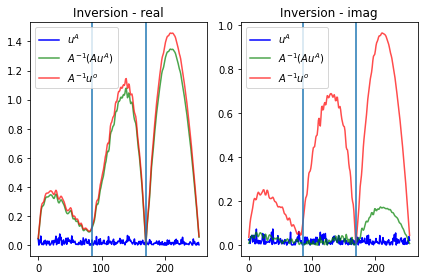

In [6]:
thSize = 200; lmax = 95; t = 11; maxSize = lmax + 1 - t
minVal = 1e-5
thF = np.linspace(minVal, pi-minVal, 2*thSize).reshape(2*thSize, 1)
theta = thF[thF<pi/2]
urIP = 10*(np.random.rand(2*thSize, thSize) - 0.5)
utIP = 10*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
upIP = 10*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
velIP = urIP, utIP, upIP

ulm, vlm, wlm, ulmA, vlmA, wlmA = vel_spectra(velIP, thSize, minVal, lmax, t)
"""
ulmA = np.zeros(ulmA.shape[0]); ulmA[0] = 10
vlmA = np.zeros(ulmA.shape[0]); vlmA[0] = 10
wlmA = np.zeros(ulmA.shape[0]); wlmA[0] = 10
"""
# using real matrices (absorbing i in definition of w_{lm})
uA = np.concatenate((ulmA, vlmA, 1j*wlmA), axis=0)
uop = np.concatenate((ulm, vlm, 1j*wlm), axis=0)
Afull = gen_full_mat3_real(t, lmax, theta)#.transpose()
np.savez_compressed("mat_new.npz", A=Afull, t=t, lmax=lmax, theta=theta)

uop2 = Afull.dot(uA)
#uA = np.concatenate((ulmA*10, vlmA/2, wlmA/3), axis=0)
AinvFull = inv_reg2(Afull, 1e-1)
#AinvFull = inv_SVD(Afull, 1e3)
uInverted = AinvFull.dot(uop)
uInverted2 = AinvFull.dot(uop2)# * (1 + 0.05*np.random.rand())) 
diff = (uop2 - uop)/uop*100

plt.figure()
plt.subplot(121)
plt.plot(abs(uA.real), 'b', label="$u^A$")
plt.plot(abs(uInverted2.real), 'g', label="$A^{-1}( A u^A )$", alpha=0.7)
plt.plot(abs(uInverted.real), 'r', label="$A^{-1} u^o$", alpha=0.7)
plt.axvline(x=maxSize)
plt.axvline(x=2*maxSize)
plt.title("Inversion - real")
plt.legend()

plt.subplot(122)
plt.plot(abs(uA.imag), 'b', label="$u^A$")
plt.plot(abs(uInverted2.imag), 'g', label="$A^{-1}( A u^A )$", alpha=0.7)
plt.plot(abs(uInverted.imag), 'r', label="$A^{-1} u^o$", alpha=0.7)
plt.axvline(x=maxSize)
plt.axvline(x=2*maxSize)
plt.title("Inversion - imag")
plt.legend()

"""
plt.subplot(223)
plt.plot(uop.real, 'b', label="$u^o$")
plt.plot(uop2.real, 'r', label="$Au^A$", alpha=0.7)
plt.axvline(x=maxSize)
plt.axvline(x=2*maxSize)
plt.title("Fwd problem - real")
plt.legend()

plt.subplot(224)
plt.plot(uop.imag, 'b', label="$u^o$")
plt.plot(uop2.imag, 'r', label="$Au^A$", alpha=0.7)
plt.axvline(x=maxSize)
plt.axvline(x=2*maxSize)
plt.title("Fwd problem - imag")
plt.legend()
"""

plt.tight_layout()
plt.show()

#plt.figure()
#plt.plot(diff)
#plt.show()

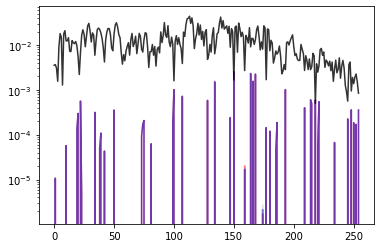

In [7]:
#AinvFull = inv_reg1(Afull, 1e-4)
u = uA.copy(); b = uop.copy(); A = Afull.copy(); u0 = uInverted.copy();
u1 = u0.copy()
x = np.zeros( uop2.shape, dtype=complex)
u1 = u1 + x
P1 = inv_reg1(Afull, 1e-5)
A2 = Afull.dot(P1)
m1 = - Afull.dot(P1) + np.identity(Afull.shape[0])
x =  P1.dot( m1.dot(b) ) 
x1 = m1.dot(x)
#mask = ~( (abs(Afull.dot(u0)) - abs(b)) < 1e-7 )
mask = np.ones(u0.shape, dtype=np.bool)
plt.figure()
plt.semilogy(abs(Afull.dot(u0))[mask] - abs(b)[mask], 'r', alpha=0.5)
plt.semilogy(abs(Afull.dot(u0 + x))[mask] - abs(b)[mask], 'b', alpha=0.5)
plt.semilogy(abs(Afull.dot(u0 + x + x1))[mask] - abs(b)[mask], 'black', alpha=0.1)
plt.semilogy(abs(b)[mask], 'black', alpha=0.8)
plt.show()

In [8]:
def generate_synthetic(excitationType, maxIndex):
    ulm = np.zeros(maxIndex, dtype=complex)
    vlm = np.zeros(maxIndex, dtype=complex)
    wlm = np.zeros(maxIndex, dtype=complex)
    #ulm = np.zeros(maxIndex, dtype=np.int)
    #vlm = np.zeros(maxIndex, dtype=np.int)
    #wlm = np.zeros(maxIndex, dtype=np.int)
    a, b = 5.0, 0.32
    countm, countl = 0, 0
    if excitationType=='sectoral':
        for i in range(maxIndex):
            if (countl - countm) < 10:
                dml = countl - countm
                ulm[i] = a*countl/(a + np.exp(dml*b))*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
                vlm[i] = 10*a*countl/(a + np.exp(dml*b))*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
                wlm[i] = 10*a*countl/(a + np.exp(dml*b))*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            if countm==countl:
                countm = 0
                countl += 1
            else:
                countm += 1
    elif excitationType=='tesseral':
        for i in range(maxIndex):
            if (countm > 7) and (countl - countm) < 7:
                dml = abs(countl/2 - countm)
                ulm[i] = a*countl/(a + np.exp(dml*b))*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
                vlm[i] = 10*a*countl/(a + np.exp(dml*b))*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
                wlm[i] = 10*a*countl/(a + np.exp(dml*b))*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            if countm==countl:
                countm = 0
                countl += 1
            else:
                countm += 1
    elif excitationType=='zonal':
        for i in range(maxIndex):
            if countm < 10:
                dml = countm
                ulm[i] = a*countl/(a + np.exp(dml*b))*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
                vlm[i] = 10*a*countl/(a + np.exp(dml*b))*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
                wlm[i] = 10*a*countl/(a + np.exp(dml*b))*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            if countm==countl:
                countm = 0
                countl += 1
            else:
                countm += 1
    elif excitationType=='solarlike':
         for i in range(maxIndex):
            logl = np.log(countl+1)
            #*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            ulm[i] = np.exp( (60*logl - logl**2)/1000 )*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            vlm[i] = np.exp( (1.5*( 60*logl - logl**2 ) + 1200)/1000 )*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            wlm[i] = np.exp( 1 + 0.04*logl )*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            if countm==countl:
                countm = 0
                countl += 1
            else:
                countm += 1
    elif excitationType=='sparse':
         for i in range(maxIndex):
            a = np.random.rand()
            b = np.random.rand()
            c = np.random.rand()
            logl = np.log(countl+1)
            if a>0.5:
                ulm[i] = np.exp( (60*logl - logl**2)/1000 )*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            else:
                ulm[i] = 0.0
            if b>0.5:
                vlm[i] = np.exp( (1.5*( 60*logl - logl**2 ) + 1200)/1000 )*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            else:
                vlm[i] = 0.0
            if c>0.5:
                wlm[i] = np.exp( 1 + 0.04*logl )*( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            else:
                wlm[i] = 0.0
            if countm==countl:
                countm = 0
                countl += 1
            else:
                countm += 1
   
    elif excitationType=='hathaway':
        ufit = np.load("u_poly.npz")['u']
        vfit = np.load("v_poly.npz")['v']
        wfit = np.load("w_poly.npz")['w']
        ellu = np.load("u_poly.npz")['ellu']
        ellv = np.load("v_poly.npz")['ellv']
        ellw = np.load("w_poly.npz")['ellw']
        for i in range(maxIndex):
            if countl<ellu[0].max():
                upoly = np.poly1d(ufit[0])
            else:
                upoly = np.poly1d(ufit[1])
            
            if countl<ellv[0].max():
                vpoly = np.poly1d(vfit[0])
            else:
                vpoly = np.poly1d(vfit[1])
            
            if countl<ellw[0].max():
                wpoly = np.poly1d(wfit[0])
            else:
                wpoly = np.poly1d(wfit[1])
                
            ulm[i] = upoly(countl) / np.sqrt( 2*countl + 1 ) * 2 * (np.random.rand() + 1j*np.random.rand())
            vlm[i] = vpoly(countl) / np.sqrt( 2*countl + 1 ) * 2 * (np.random.rand() + 1j*np.random.rand())
            wlm[i] = wpoly(countl) / np.sqrt( 2*countl + 1 ) * 2 * (np.random.rand() + 1j*np.random.rand())
            if countm==countl:
                countm = 0
                countl += 1
            else:
                countm += 1
    
    else:
        for i in range(maxIndex):
            ulm[i] = countl**0.75 *( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            vlm[i] = 10*countl**0.75 *( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            wlm[i] = 10*countl**0.75 *( (np.random.rand() - 0.5) + 1j*(np.random.rand() - 0.5) )
            if countm==countl:
                countm = 0
                countl += 1
            else:
                countm += 1
    return ulm, vlm, wlm

In [53]:
# generating spectrum for allt
thSize = 200; lmax = 150; phSize = thSize;
minVal = 1e-5
thF = np.linspace(minVal, pi-minVal, 2*thSize).reshape(2*thSize, 1)
theta = thF[thF<pi/2]
"""
urIP = 1*(np.random.rand(2*thSize, thSize) - 0.5)
utIP = 1*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
upIP = 1*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
velIP = urIP, utIP, upIP

ulm, vlm, wlm, ulmA, vlmA, wlmA = vel_spectra_allt(velIP, thSize, minVal, lmax)
"""
maxIndex = int( (lmax+1)*(lmax+2)/2 )
ellArr = np.zeros(maxIndex, dtype=np.int32)
emmArr = np.zeros(maxIndex, dtype=np.int32)
excitationType = 'sectoral'
#excitationType = 'tesseral'
#excitationType = 'zonal'
#excitationType = 'random'
excitationType = 'hathaway'
#excitationType = 'solarlike'
#excitationType = 'sparse'
ulmo, vlmo, wlmo = generate_synthetic(excitationType, maxIndex)

#ulm[:10] = a/( a + np.exp(np.arange(10)*b))
#vlm[:10] = a/( a + np.exp(np.arange(10)*b))
#wlm[:10] = a/( a + np.exp(np.arange(10)*b))
urIP, utIP, upIP = vel_from_spectra_allt(ulmo, vlmo, wlmo, 2*thSize, phSize, lmax)
velIP = urIP, utIP, upIP
ulm, vlm, wlm, ulmA, vlmA, wlmA = vel_spectra_allt(velIP, thSize, minVal, lmax)
countl, countm = 0, 0
for i in range(maxIndex):
    ellArr[i] = countl
    emmArr[i] = countm
    if countm==countl:
        countm = 0
        countl += 1
    else:
        countm += 1
np.savez_compressed("/home/g.samarth/dopplervel2/alm.npz", ulm=ulm, vlm=vlm, wlm=wlm)
np.savez_compressed("/home/g.samarth/dopplervel2/almA.npz", ulm=ulmA, vlm=vlmA, wlm=wlmA)
np.savez_compressed("/home/g.samarth/dopplervel2/arrlm.npz", ellArr=ellArr, emmArr=emmArr)

In [54]:
def computePS(alm, lmax, ellArr, emmArr):
    '''Computes the power spectrum given the spectral coefficients.

    Parameters:
    -----------
    alm - np.ndarray(ndim=1, dtype=complex)
        array of all spectral coefficients (upto lmax)
    lmax - int 
        maximum spherical harmonic degree
    ellArr - np.ndarray(ndim=1, dtype=int)
        array containing ell 
    emmArr - np.ndarray(ndim=1, dtype=int)
        array containing emm
    
    Returns:
    --------
    ps - np.ndarray(ndim=1, dtype=float)
        power spectrum 
    
    Notes:
    ------
    The velocity power spectrum is given by ell * \sum_{m} | alm |^2
    
    '''
    ps = np.zeros(lmax)
    for i in range(lmax):
        isel = ellArr==i
        ps[i] += (abs(alm[isel])**2).sum() * i# / (2*i + 1)
    return np.sqrt(ps)


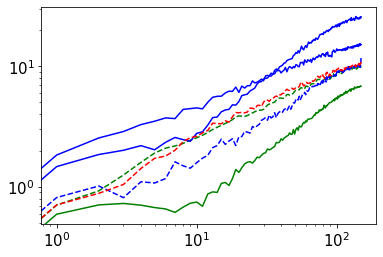

In [55]:
ulmA = np.load("almA.npz")['ulm']
vlmA = np.load("almA.npz")['vlm']
wlmA = np.load("almA.npz")['wlm']
_psuA = computePS(ulmA, lmax, ellArr, emmArr)
_psvA = computePS(vlmA, lmax, ellArr, emmArr)
_pswA = computePS(wlmA, lmax, ellArr, emmArr)
_psu = computePS(ulm, lmax, ellArr, emmArr)
_psv = computePS(vlm, lmax, ellArr, emmArr)
_psw = computePS(wlm, lmax, ellArr, emmArr)
ell = np.arange(lmax) + 1
plt.figure()
plt.loglog(np.sqrt(_psu), '--g')
plt.loglog(np.sqrt(_psuA), 'g')
plt.loglog(np.sqrt(_psv), '--b')
plt.loglog(np.sqrt(_psvA), 'b')
plt.loglog(np.sqrt(_psw), '--r')
plt.loglog(np.sqrt(_pswA), 'b')
plt.show()

loading files --
loading files -- complete
lmax = 150, thSize = 200
computing for .... 
Time taken for t = 0: 0.004 min,(0.004 min)
Time taken for t = 20: 0.000 min,(0.014 min)
Time taken for t = 40: 0.000 min,(0.022 min)
Time taken for t = 60: 0.000 min,(0.027 min)
Time taken for t = 80: 0.000 min,(0.031 min)
Time taken for t = 100: 0.000 min,(0.034 min)
Time taken for t = 120: 0.000 min,(0.036 min)
Time taken for t = 140: 0.000 min,(0.038 min)
Total time taken = 0.039 minutes


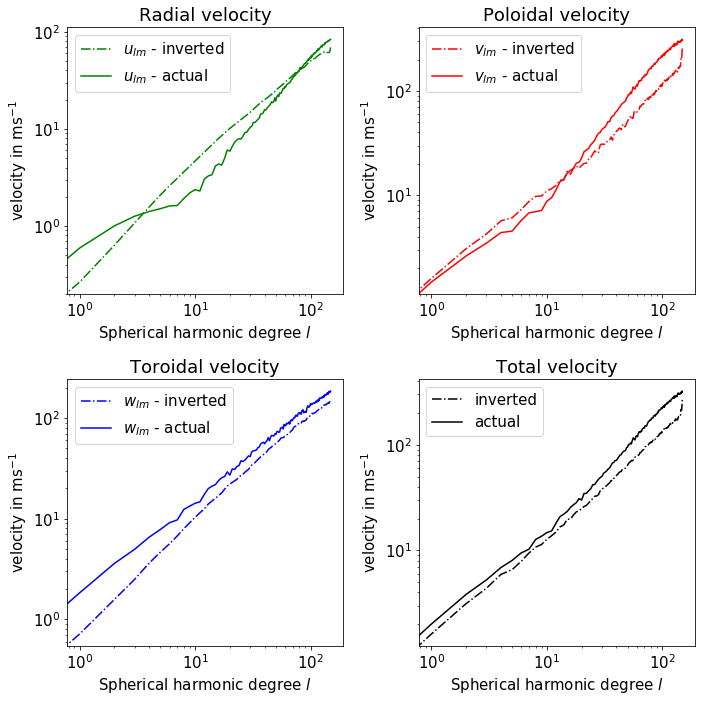

In [59]:
%run inversion.py --cchpc --synth --gnup 15 --read

In [ ]:
temp1 = np.linspace(0, 10, 10)
temp2 = np.linspace(0, 5, 15)
c = (temp1, temp2)

In [ ]:
alm = np.load("alm.data.inv001.npz")
ulm = alm['ulm']
vlm = alm['vlm']
wlm = alm['wlm']

In [ ]:
c[0] - temp1

In [ ]:
%run rotation.py --cchpc --gnup 15

In [ ]:
plt.figure()
plt.loglog(uth[:, 0], uth[:, 1], 'g')
plt.loglog(vth[:, 0], v'r')
plt.loglog(wth[:, 0], 'b')
plt.show()

In [ ]:
%run inversion.py --synth --cchpc --read
%run inversion.py --synth --cchpc --read --l1
%run inversion.py --synth --cchpc --read --fat
%run inversion.py --synth --cchpc --read --fat --l1
#%run plot_ps.py

In [ ]:
%run inversion.py --hpc --read
%run inversion.py --hpc --read --l1
#%run inversion.py --hpc --read --fat
#%run inversion.py --hpc --read --fat --l1
#%run plot_ps.py

In [ ]:
s = 10
maskell = ellArr==s
mask2 = abs(vlmA)>0
plt.figure()
plt.plot(abs(ulmA)[maskell * mask2], '.b')
plt.plot(abs(ulm)[maskell * mask2], '.r')
plt.show()
plt.close()

In [ ]:
plt.figure()
plt.semilogy(abs(uop2.real/uop.real), '*r', alpha=0.5)
plt.semilogy(abs(uop2.imag/uop.imag), '.b', alpha=0.4)
plt.show()
plt.plot(ulm.real, 'g')

In [ ]:
totsize = int(uop2.shape[0]/3)
ulmop, vlmop, wlmop = uInverted[:totsize], uInverted[totsize:2*totsize], uInverted[2*totsize:]
phSize = thSize
urInv, utInv, upInv = vel_from_spectra(ulmop, vlmop, wlmop, 2*thSize, phSize, lmax, t)
ur, ut, up = vel_from_spectra(ulmA, vlmA, wlmA, 2*thSize, phSize, lmax, t)

In [ ]:
plt.figure()

plt.subplot(331)
im = plt.imshow(ur.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_r$ - actual')
plt.subplot(332)
im = plt.imshow(urInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_r$ - Inverted')
plt.subplot(333)
im = plt.imshow(ur.real - urInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_r$ - Diff')

plt.subplot(334)
im = plt.imshow(ut.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_t$ - actual')
plt.subplot(335)
im = plt.imshow(utInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_t$ - Inverted')
plt.subplot(336)
im = plt.imshow(ut.real - utInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_t$ - Diff')

plt.subplot(337)
im = plt.imshow(up.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_p$ - actual')
plt.subplot(338)
im = plt.imshow(upInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_p$ - Inverted')
plt.subplot(339)
im = plt.imshow(up.real - upInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_p$ - Diff')

plt.tight_layout()
plt.show()

plt.figure()
uipmag = np.sqrt(abs(ur)**2 + abs(ut)**2 + abs(up)**2)
uInvmag = np.sqrt(abs(urInv)**2 + abs(utInv)**2 + abs(upInv)**2)
plt.subplot(131)
im = plt.imshow(uipmag, cmap='seismic')
plt.colorbar(im)
plt.title('$|u|$ - actual')
plt.subplot(132)
im = plt.imshow(uInvmag, cmap='seismic')
plt.colorbar(im)
plt.title('$|u|$ - Inverted')
plt.subplot(133)
im = plt.imshow(uipmag - uInvmag, cmap='seismic')
plt.colorbar(im)
plt.title('$|u|$ - Diff')

plt.tight_layout()
plt.show()

#theta = np.linspace(1e-5, pi - 1e-5, 2*thSize)
lr = np.cos(theta); lt = -np.sin(theta)
ipVelLOS = ur[:thSize, :]*lr.reshape(thSize, 1) + ut[:thSize, :]*lt.reshape(thSize, 1)
invVelLOS = urInv[:thSize, :]*lr.reshape(thSize, 1) + utInv[:thSize, :]*lt.reshape(thSize, 1)

maxVel = max( ipVelLOS.real.max(), invVelLOS.real.max() )
minVel = max( ipVelLOS.real.min(), invVelLOS.real.min() )
bigMax = max( abs(maxVel), abs(minVel) )

plt.figure()
plt.subplot(221)
im = plt.imshow(ipVelLOS.real, vmax=bigMax, vmin=-bigMax, cmap='seismic')
plt.colorbar(im)
plt.title('input')

plt.subplot(222)
im = plt.imshow(invVelLOS.real, vmax=bigMax, vmin=-bigMax, cmap='seismic')
plt.colorbar(im)
plt.title('inverted')

plt.subplot(223)
im = plt.imshow( invVelLOS.real - ipVelLOS.real, vmax=bigMax, vmin=-bigMax, cmap='seismic')
plt.colorbar(im)
plt.title('diff')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure()
im = plt.imshow(invVelLOS.real - ipVelLOS.real, cmap='seismic')
plt.colorbar(im)
plt.show()
oooo

In [ ]:
diver = hor_div(ut[:thSize, :].real, up[:thSize, :].real, theta, phi)
diverInv = hor_div(utInv[:thSize, :].real, upInv[:thSize, :].real, theta, phi)
plt.figure()
plt.subplot(121)
im = plt.imshow(diver, cmap='seismic')
plt.colorbar(im)
plt.title('Div - actual')

plt.subplot(122)
im = plt.imshow(diverInv, cmap='seismic')
plt.colorbar(im)
plt.title('Div - inverted')

plt.tight_layout()
plt.show()

In [ ]:
powerSpec.shape